In [2]:
import pandas as pd
import numpy as np
from transformers import BertTokenizer, TFBertForSequenceClassification, DistilBertTokenizer, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tf_keras.callbacks import CSVLogger, ModelCheckpoint
import tf_keras
import warnings
warnings.filterwarnings("ignore")

In [18]:
jeopardy = pd.read_csv('jeopardy.csv')
train, other = train_test_split(jeopardy, test_size=0.4, random_state=42, stratify=jeopardy['class'])
dev, test = train_test_split(other, test_size=0.5, random_state=42, stratify=other['class'])
train.to_csv('splits/train.txt', index=False)
dev.to_csv('splits/dev.txt', index=False)
test.to_csv('splits/test.txt', index=False)

In [19]:
# Function to preprocess and encode datasets
def prepare_data(data):
    data['combined_text'] = data['Category'] + " [SEP] " + data['Question'] + " [SEP] " + data['Answer']
    # Ensure to use the 'text' parameter for the tokenizer
    input_data = tokenizer(text=data['combined_text'].tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="tf")
    labels = label_encoder.transform(data['class'])  # Transform labels using the fitted label encoder
    return input_data['input_ids'], tf.keras.utils.to_categorical(labels, num_classes=len(label_encoder.classes_))


model_name = 'distilbert-base-uncased'
# Initialize and fit label encoder on all possible labels
label_encoder = LabelEncoder()
all_data = pd.concat([train, dev, test])
label_encoder.fit(all_data['class'])

# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
# Initialize model
model = TFDistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Prepare datasets
train_inputs, train_labels = prepare_data(train)
dev_inputs, dev_labels = prepare_data(dev)
test_inputs, test_labels = prepare_data(test)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(len(train_labels)).batch(32)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels)).batch(32)



# Compile model
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf_keras.optimizers.legacy.Adam(learning_rate=1e-5)
csv_logger = CSVLogger("model.csv")
checkpoint = ModelCheckpoint("model.keras", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')


model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train model
model.fit(train_dataset, epochs=25, validation_data=dev_dataset, callbacks=[csv_logger, checkpoint])

# Evaluate model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/25
10/10 [==============================] - ETA: 0s - loss: 1.2254 - accuracy: 0.6233
Epoch 1: val_loss improved from inf to 1.06701, saving model to model.keras
10/10 [==============================] - 35s 2s/step - loss: 1.2254 - accuracy: 0.6233 - val_loss: 1.0670 - val_accuracy: 0.6400
Epoch 2/25
10/10 [==============================] - ETA: 0s - loss: 1.0380 - accuracy: 0.6433
Epoch 2: val_loss improved from 1.06701 to 1.01825, saving model to model.keras
10/10 [==============================] - 12s 1s/step - loss: 1.0380 - accuracy: 0.6433 - val_loss: 1.0183 - val_accuracy: 0.6400
Epoch 3/25
10/10 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.6433
Epoch 3: val_loss improved from 1.01825 to 1.00008, saving model to model.keras
10/10 [==============================] - 11s 1s/step - loss: 0.9958 - accuracy: 0.6433 - val_loss: 1.0001 - val_accuracy: 0.6400
Epoch 4/25
10/10 [==============================] - ETA: 0s - loss: 0.9877 - accuracy: 0.6433
E

In [21]:
majority_class = test['class'].value_counts().idxmax()
majority_class_accuracy = (test['class'] == majority_class).mean()
print(f"Majority Class Baseline: {majority_class_accuracy}")

Majority Class Baseline: 0.65


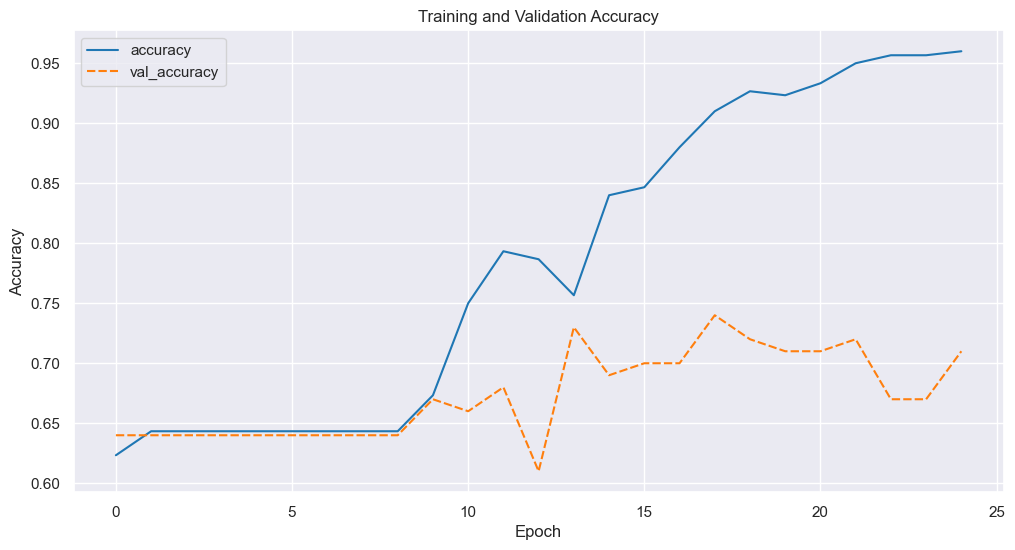

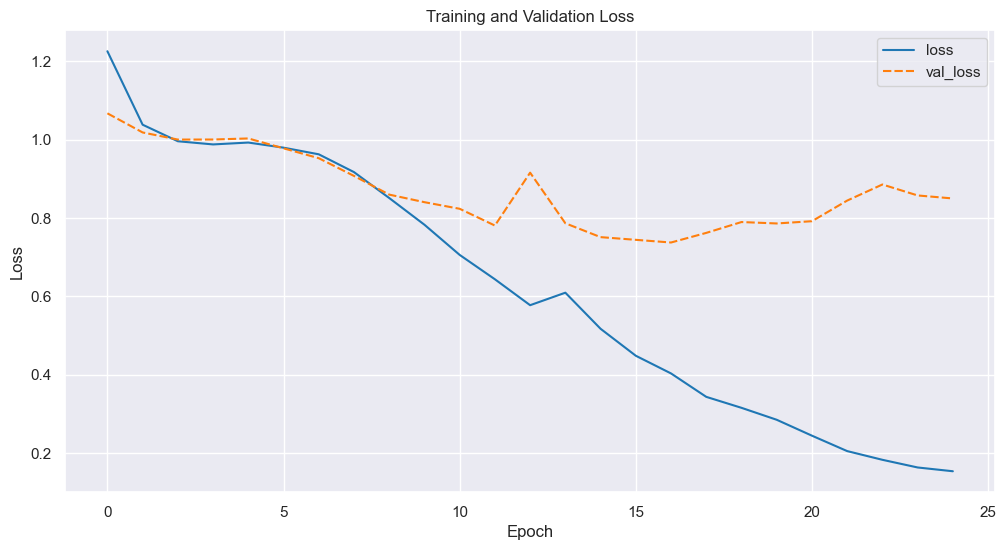

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid', palette="tab10", context='notebook')
performance = pd.read_csv('model.csv')
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance[['accuracy', 'val_accuracy']])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()
plt.figure(figsize=(12, 6))
sns.lineplot(data=performance[['loss', 'val_loss']])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()